In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata
#from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture


from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns


In [2]:
class GaussianMixtureModel:
    '''
     This class implements a Gaussian Mixture Model which has several methods for 
     data generation, likelihood calculation, and visualization of the results.
     
    '''
    def __init__(self, n_dimensions, n_components, means, covs, weights):
        '''
        Initializes the class with the number of dimensions, number of components, 
        means, covariance matrices, and weights for each dimension.
        
        Arguments
        n_dimensions [int]: number of dimensions of dataset
        n_components [int]: number of components in the input data
        means [list]: means for each Gaussian component
        covs [list]: covariance matrices for each Gaussian component
        weights [list]: weights for each Gaussian component
        
        '''
        self.n_dimensions = n_dimensions
        self.n_components = n_components
        self.means = means
        self.covs = covs
        self.weights = weights
        # initialize the noisy_data attribute to None
        self.noisy_data = None

        
    def generate_data(self, n_samples, noise_scale=None):
        '''
        Generate data with Poisson flucuations
        
        Arguments
        X [np.ndarra]: initial dataset we generate
        noise_scale [float or None]: standard deviation of the Poisson noise added to the data
        
        Returns 
        None
        
        '''
        
        X = np.zeros((n_samples, self.n_dimensions))
        c = np.random.choice(self.n_components, size=n_samples, p=self.weights)
        for i in range(self.n_components):
            idx = (c == i)
            X[idx, :] = np.random.multivariate_normal(mean=self.means[i], cov=self.covs[i], size=np.sum(idx))

        # first create a numpy histogram from the GMM
        bins = 30
        data_hist, bin_edges = np.histogramdd(X, bins=bins)
        bin_centers = []
        for i in range(self.n_dimensions):
            bin_centers.append((bin_edges[i][:-1] + bin_edges[i][1:]) / 2.0)

        # add Poisson fluctuations to the value in each bin
        # it takes the expected values for the Poisson distribution 
        # and generates a new numpy array with Poisson fluctuations around these expected values
        noisy_data_hist = np.random.poisson(lam=data_hist)

        noisy_data = np.array(np.meshgrid(*bin_centers)).T.reshape(-1,self.n_dimensions) # reshpae
        noisy_data = noisy_data.repeat(noisy_data_hist.flatten(), axis=0) # flattened
        noisy_data = noisy_data + np.random.normal(scale=noise_scale, size=noisy_data.shape)
        self.noisy_data = noisy_data

        return X, noisy_data

    
    
    def plot_scatter(self, X):
        '''
        Plots scatter plot for data.
        
        Arguments
        X [np.array]: dataset for which scatter plot will be plotted
        
        Returns
        None
                
        '''
        plt.rcParams["figure.figsize"] = (8, 6)
        
        n_dimensions = X.shape[1]
        
        # 2D data
        if n_dimensions == 2:
            plt.scatter(X[:, 0], X[:, 1], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            plt.xlabel("$\mu1$")
            plt.ylabel("$\mu2$")
            plt.savefig('2Dscatter')
            plt.show()
        
        # 3D data
        elif n_dimensions == 3:
            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')
            ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker = 'o', s = 6, alpha = 0.5)
            plt.title("Scatter plot for Gaussian Mixture Model")
            ax.set_xlabel("$\mu1$")
            ax.set_ylabel("$\mu2$")
            ax.set_zlabel("$\mu3$")
            plt.savefig('3Dscatter')
            plt.show()


    def plot_scatters(self, Xs, labels, figsize=(8,6)):
        '''
        Plots scatter plot for data.
        
        Arguments
        Xs List[np.array]: the list of datasets for which scatter plot will be plotted
        labels List[str]: the list of the label of each dataset will be plotted
        figsize : the fig size of the output plot
        
        Returns
        None
                
        '''


        plt.rcParams["figure.figsize"] = figsize
            
        n_dimensions = Xs[0].shape[1]
            
        # 2D data
        if n_dimensions==2:
            for i, X in enumerate(Xs):
                plt.scatter(X[:, 0], X[:, 1], marker = 'o', s = 6, alpha = 0.5, label=labels[i])
                plt.title("Scatter plot for Gaussian Mixture Model")
                plt.legend(fontsize=min(figsize)*2)
                plt.xlabel("$\mu1$")
                plt.ylabel("$\mu2$")
            plt.savefig('2Dscatter')
            
        # 3D data
        elif n_dimensions == 3:
            for i, X in enumerate(Xs):
                fig = plt.figure(min(figsize))
                ax = fig.add_subplot(111, projection = '3d')
                ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker = 'o', s = 6, alpha = 0.5, label=labels[i])
                plt.title("Scatter plot for Gaussian Mixture Model")
                ax.legend(fontsize=min(figsize)*2)
                ax.set_xlabel("$\mu1$")
                ax.set_ylabel("$\mu2$")
                ax.set_zlabel("$\mu3$")
            plt.savefig('2Dscatter')

        plt.show()



    def plot_histograms(self, X, noise_scale=None):
        '''
        Plots histograms for data.

        Arguments:
        X [np.array]: dataset for which histograms will be plotted
        noise_scale [float]: standard deviation of the Poisson noise added to the data

        Returns:
        None

        '''
        n_dimensions = X.shape[1]

        fig, axs = plt.subplots(n_dimensions, figsize=(6, 3*self.n_dimensions))

        for i in range(n_dimensions):
            if noise_scale is not None:
                noisy_data = np.random.normal(X[:, i], scale=noise_scale)
                noisy_counts, noisy_edges = np.histogram(noisy_data, bins=30)
                noisy_bin_centers = (noisy_edges[:-1] + noisy_edges[1:]) / 2.0

                # Fit a Gaussian mixture model to the noisy data
                gmm = GaussianMixture(n_components=self.n_components, covariance_type='full', max_iter=100)
                gmm.fit(noisy_data.reshape(-1, 1))

            else:
                noisy_counts, noisy_bin_centers = None, None

            data_counts, data_edges = np.histogram(X[:, i], bins=30)
            data_bin_centers = (data_edges[:-1] + data_edges[1:]) / 2.0

            data_bars = axs[i].bar(data_bin_centers, data_counts, alpha=0.5, label='Data', width=(data_bin_centers[1] - data_bin_centers[0]))

            if noise_scale is not None:
                noisy_points = axs[i].scatter(data_bin_centers, noisy_counts, color='red', label='Noisy data')

            # Plot the Gaussian mixture fit for the noisy data
            if noise_scale is not None:
                x = np.linspace(data_bin_centers.min(), data_bin_centers.max(), 1000).reshape(-1, 1)
                log_prob = gmm.score_samples(x)
                best_fit, = axs[i].plot(x, np.exp(log_prob) * len(noisy_data) * (data_bin_centers[1] - data_bin_centers[0]), linewidth=2, label='Best fit')
            else:
                best_fit = None

            if noise_scale is not None:
                handles = [data_bars, noisy_points, best_fit]
            else:
                handles = [data_bars, best_fit]

            axs[i].legend(handles=handles)

        fig.tight_layout()
        plt.show()





    def pdf(self, X):
        '''
        Calculates the probability density function (pdf) of the Gaussian Mixture Model 
        for a given set of samples in X.
    
    
            p(x_j|θ) is the probability density function at each independent sample with
            θ represents the parameters mean, covariance, and mixture coefficients,
            and x_1, x_2, ... , x_n are the observed samples in dataset X.
        
        
        Arguments
        X [np.array]: dataset for which pdf will be calculated
        Returns
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        '''

        X = np.asarray(X)

        if len(X.shape)==1:
            prob = 0
            
            for i in range(self.n_components):
                prob += self.weights[i]*multivariate_normal.pdf(X, self.means[i], self.covs[i])
            return prob

        else:
            prob = np.zeros((X.shape[0], self.n_components)) # initialize a numpy array of zeros to store probs of each sample


            for i in range(self.n_components):
                prob[:,i] = self.weights[i]*multivariate_normal.pdf(X, self.means[i], self.covs[i])

            probs = np.sum(prob, axis=1)

            return probs

         
    def calculate_log_likelihoods(self, params):
        '''
        Calculates the log-likelihood of the Gaussian Mixture Model for a given parameter
        
            The likelihood is calculated as the product of individual pdfs at the observed samples:
            L(θ) = p(x_1, x_2, ..., x_N|θ) = Π_j=1^N p(x_j|θ)

            Since likelihood of each point may be very small, leading to extremely small products, 
            a log likelihood is often used in practice:
            logL(θ) = Σ_j=1^N log(p(x_j|θ)) 

        Arguments
        params [list]: list of tuples containing the mean and covariance for each Gaussian component
                             in shape of [([mean], [[cov]), ([mean], [[cov]),..., ([mean], [[cov])]
        
        Returns
        log_likelihoods [np.array]: log-likelihood from parameters

        '''
        
        log_likelihoods = np.zeros(self.noisy_data.shape[0]) # initialize a numpy array of zeros to store log-likelihoods of each sample

        for i, x in enumerate(self.noisy_data):
            log_likelihood = 0
            for j in range(self.n_components):
                # calculate log-likelihood of each sample by
                # adding product of mixture coefficient and pdf at sample x_j for each Gaussian component k
                log_likelihood += self.weights[j] * multivariate_normal.pdf(x, mean = params[j][0], cov = params[j][1])
            log_likelihoods[i] = np.log(log_likelihood) # store in log_likelihoods numpy array

        return log_likelihoods # return log-likelihood of each sample in dataset X


    def plot_log_likelihood(self, X, probs):
        '''
        Plots the log-likelihood surface of data.
        Arguments
        X [np.array]: dataset for which scatterplot will be plotted
        probs [np.array]: probabilities of the Gaussian Mixture Model for each sample in X
        
        Returns
        None
        '''
        
        if self.n_dimensions == 2:
            fig = plt.figure(figsize = (8, 8), facecolor = "white")
            ax = fig.add_subplot(projection = "3d")
            
            x = X[:, 0]
            y = X[:, 1]
            z = probs
            
            # interpolate the points to make the plot smoother
            xi = np.linspace(min(x), max(x), 500)
            yi = np.linspace(min(y), max(y), 500)
            X, Y = np.meshgrid(xi, yi)
            Z = griddata((x, y), z, (X, Y), method='cubic')

            # plot the wireframe
            ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
            
            # plot scatter plot
            ax.scatter(x, y, z, color = 'r',  marker = '.', alpha = 0.7)

            ax.set_xlabel("mu1")
            ax.set_ylabel("mu2")
            ax.set_zlabel("Likelihood")
            ax.set_title("Likelihood Plot")
            fig.tight_layout()
            plt.savefig('likelihood')
            fig.show()

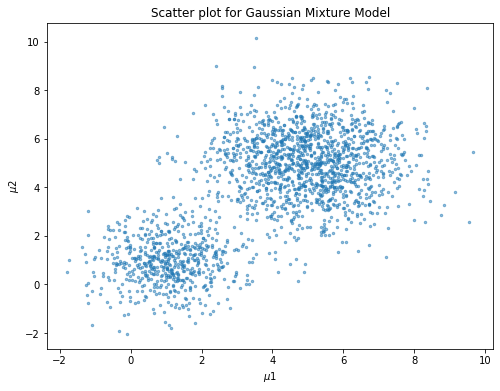

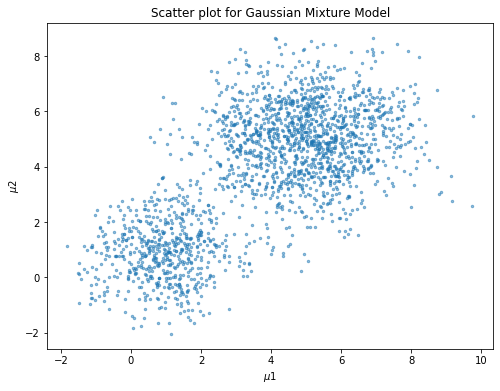

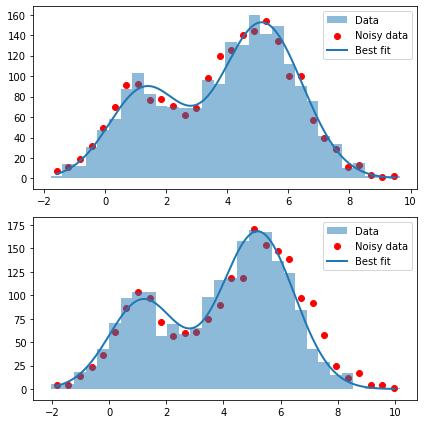

[8.98627399e-04 2.61126881e-03 3.26237381e-04 ... 2.06890052e-04
 4.60495537e-05 1.60498990e-04]
(2035,)
[ -7.32392189  -8.07398302 -10.46890967 ... -14.17336646 -16.31787356
  -7.62611277]
(2035,)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


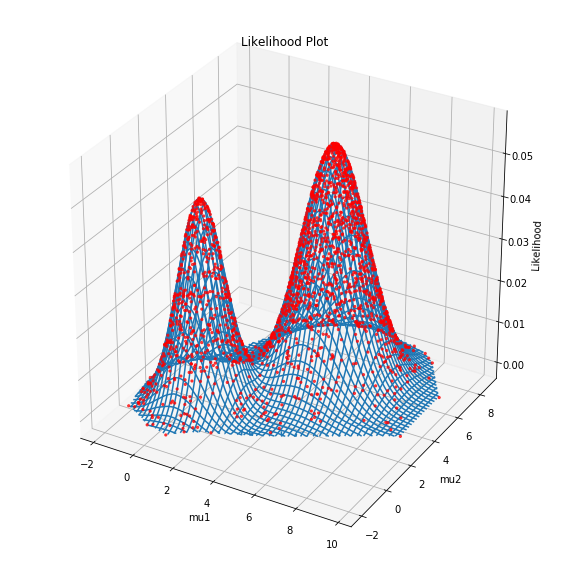

In [3]:
# Define the Gaussian Mixture Model with 2 dimensions and 2 components
dimensions = 2
components = 2

gmm1 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                            means = [[1, 1], [5, 5]], 
                            covs = [[[1, 0], [0, 1]], 
                                    [[2, 0], [0, 2]]], 
                            weights = [0.3, 0.7])

# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X1, noisy_data1 = gmm1.generate_data(n_samples, noise_scale = noise)

# Plot the data X
gmm1.plot_scatter(X1)
gmm1.plot_scatter(noisy_data1)

# Plot the histograms of data X
gmm1.plot_histograms(X1,noise_scale=noise)

# Calculate pdf of the data X 
prob1 = gmm1.pdf(noisy_data1)
print(prob1)
print(prob1.shape)

    
# Calculate log-likelihoods for input parameters
log_likelihood1 = gmm1.calculate_log_likelihoods(params = [([1, 2], [[1, 1], [0, 1]]), 
                                                                 ([3, 5], [[5, 5], [1, 1]])])

print(log_likelihood1)
print(log_likelihood1.shape)



# Plot the likelihoods of data X
gmm1.plot_log_likelihood(noisy_data1,prob1)


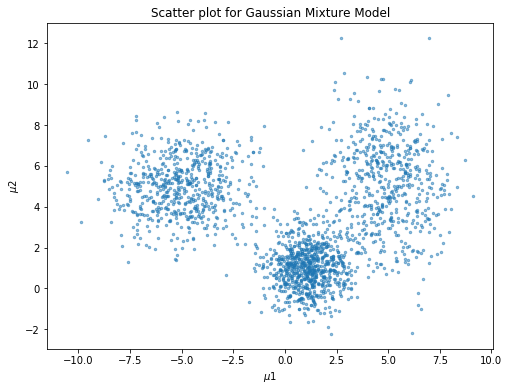

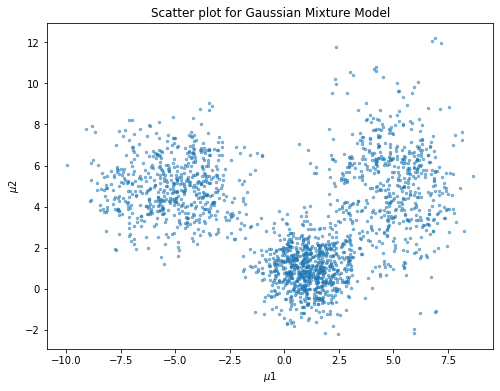

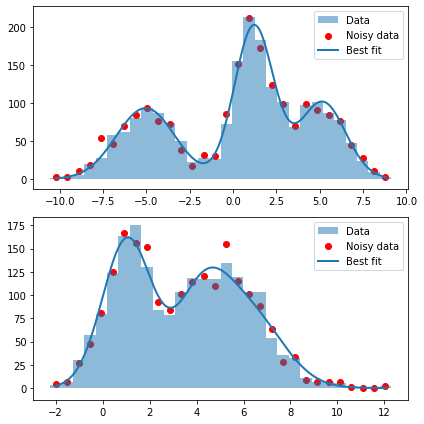

[0.00025538 0.00132379 0.00149166 ... 0.00052192 0.0007807  0.00063167]
(1986,)
[-8.27276036 -6.62725604 -6.5078677  ... -7.55799359 -7.15532359
 -7.36714169]
(1986,)


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:320: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


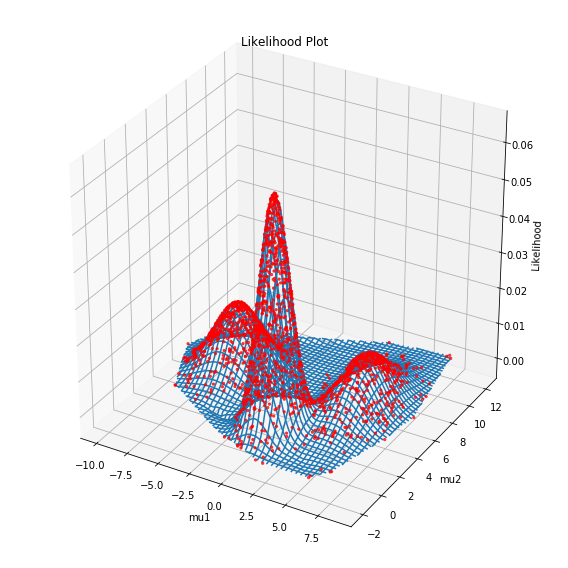

In [4]:
# Define the Gaussian Mixture Model with 2 dimensions and 3 components
dimensions = 2
components = 3

gmm2 = GaussianMixtureModel(n_dimensions = dimensions, 
                            n_components = components, 
                           means = [[1, 1], [-5, 5], [5, 5]], 
                           covs = [[[1, 0], [0, 1]], 
                                   [[3, 0], [0, 2]],
                                   [[2, 0], [0, 5]]],
                           weights = [0.4, 0.3, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X2, noisy_data2 = gmm2.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm2.plot_scatter(X2)
gmm2.plot_scatter(noisy_data2)

# Plot the histograms of data X
gmm2.plot_histograms(X2, noise_scale=noise)


# Calculate pdf of the data X 
prob2 = gmm2.pdf(noisy_data2)
print(prob2)
print(prob2.shape)


# Calculate log-likelihoods for input parameters
log_likelihood2 = gmm2.calculate_log_likelihoods(params = [([1, 1], [[1, 0], [0, 1]]), 
                                                                 ([-5, 5], [[3, 0], [0, 2]]), 
                                                                 ([5, 5], [[2, 0], [0, 5]])])

print(log_likelihood2)
print(log_likelihood2.shape)

# Plot the likelihoods of data X
gmm2.plot_log_likelihood(noisy_data2, prob2)

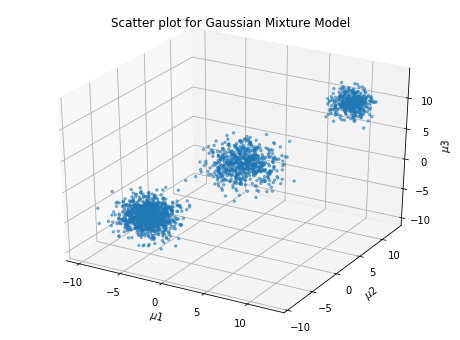

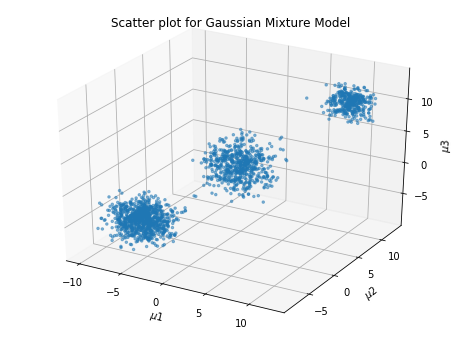

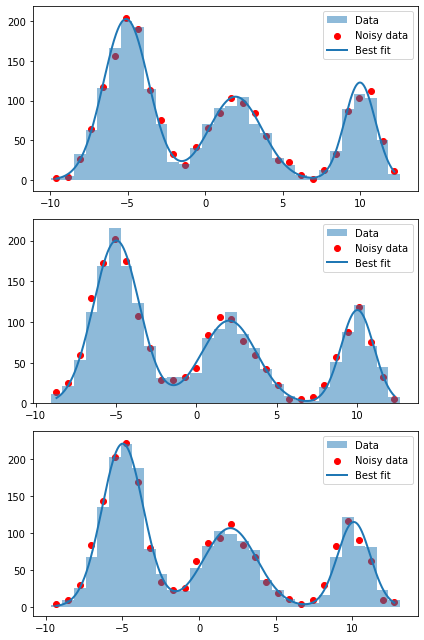

[2.43075051e-04 2.90442195e-04 2.64585090e-04 ... 2.56726570e-04
 2.19730297e-05 9.96983485e-06]
(1958,)
[ -8.16367801  -8.04498846  -8.10714957 ... -32.67208783 -30.04995919
 -30.17815508]
(1958,)


In [5]:
# Define the Gaussian Mixture Model with 3 dimensions and 3 components
dimensions = 3
components = 3

gmm3 = GaussianMixtureModel(n_dimensions = dimensions, 
                           n_components = dimensions, 
                           means = [[10, 10, 10], [-5, -5, -5], [2, 2, 2]], 
                           covs = [[[1, 0, 0], [0, 1, 0], [0, 0, 1]], 
                                   [[2, 0, 0], [0, 2, 0], [0, 0, 2]],
                                   [[3, 0, 0], [0, 3, 0], [0, 0, 3]]], 
                           weights=[0.2, 0.5, 0.3])


# Initialize the Gaussian Mixture Model class with n samples
n_samples = 2000
noise = 0.2
X3, noisy_data3 = gmm3.generate_data(n_samples, noise_scale = noise)


# Plot the data X
gmm3.plot_scatter(X3)
gmm3.plot_scatter(noisy_data3)


# Plot the histograms of data X
gmm3.plot_histograms(X3, noise_scale=noise)


prob3 = gmm3.pdf(noisy_data3)
print(prob3)
print(prob3.shape)


# Calculate the likelihood for input parameters
new_mean_and_cov = [([0, 0, 0], [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), 
                    ([5, 5, 5], [[2, 0, 0], [0, 2, 0], [0, 0, 2]]), 
                    ([-5, -5, -5], [[3, 0, 0], [0, 3, 0], [0, 0, 3]])]

log_likelihood3 = gmm3.calculate_log_likelihoods(params = new_mean_and_cov)

print(log_likelihood3)
print(log_likelihood3.shape)
